<a href="https://colab.research.google.com/github/GiuBuonafina/Classificacao_Naive_Bayes/blob/main/KG_Projeto_ED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalações e importações


In [ ]:
!pip install textacy==0.12.0

In [ ]:
import pandas as pd
import spacy
from spacy import displacy
import textacy
import networkx as nx
import matplotlib.pyplot as plt

# Pré-processamento dos dados (NLP)

In [ ]:
# Importando o conjunto de dados
df = pd.read_csv('database.csv')

In [ ]:
# Transformando em apenas um corpo textual
txt = []
for linha in df.patient:
    txt.append(linha)

txt_unido = ' '.join(txt)
print(txt_unido)

A 48 year-old female presented with vaginal bleeding. The patient had abnormal Pap smears. The diagnosis was invasive non-keratinizing SCC of the cervix. She underwent a radical hysterectomy with salpingo-oophorectomy. The surgery demonstrated positive spread to the pelvic lymph nodes. The surgery demonstrated positive spread to the parametrium. Pathological examination revealed extensive tumour involvement of the lower uterine segment. A 35 year-old male had a history of hypertension. He had type 2 diabetes mellitus. The patient presented with chest pain. The patient presented with shortness of breath. ECG indicated a myocardial infarction. Cardiac biomarkers indicated a myocardial infarction. He was taken to the catheterization lab for a coronary angiogram. He underwent stent placement. A 70 year-old female had a history of atrial fibrillation. She had a prior stroke. The patient presented with new-onset left-sided weakness. The patient presented with slurred speech. A CT scan confir

In [ ]:
nlp = spacy.load( "en_core_web_sm" )
doc = nlp(txt_unido)

In [ ]:
# De texto unido para uma lista de frases (sentenças)
lst_docs = [sent for sent in doc.sents]
print ( "total de frases:" , len(lst_docs))

total de frases: 252


In [ ]:
# Analisando o POS (Marcação de classes gramaticais) e DEP (Análise de dependência)
for token in lst_docs[0]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

A --> pos: DET | dep: det 
48 --> pos: NUM | dep: nummod 
year --> pos: NOUN | dep: npadvmod 
- --> pos: PUNCT | dep: punct 
old --> pos: ADJ | dep: amod 
female --> pos: NOUN | dep: ROOT 
presented --> pos: VERB | dep: acl 
with --> pos: ADP | dep: prep 
vaginal --> pos: ADJ | dep: amod 
bleeding --> pos: NOUN | dep: pobj 
. --> pos: PUNCT | dep: punct 


In [ ]:
# Ferramenta gráfica
from spacy import displacy

displacy.render(lst_docs[0], style="dep", options={"distance":100})

## Extração de entidades e relações

In [ ]:
# Funções responsáveis por extrair entidades e relações
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            # prefix --> prev_compound + compound
            if token.dep_ == "compound":
                prefix = prev_txt + " " + token.text if prev_dep == "compound" else token.text

            # modifier --> prev_compound + %mod
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt + " " + token.text if prev_dep == "compound" else token.text

            # subject --> modifier + prefix + %subj
            if token.dep_.find("subj") == True:
                a = modifier + " " + prefix + " " + token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""

            # if object --> modifier + prefix + %obj
            if token.dep_.find("obj") == True:
                b = modifier + " " + prefix + " " + token.text

            prev_dep, prev_txt = token.dep_, token.text

    # Limpar
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split()])
    return (a.strip(), b.strip())

# A extração de relações requer a ferramenta de correspondência baseada em regras,
# uma versão aprimorada de expressões regulares em texto bruto.
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP': 'ROOT'},
          {'DEP': 'prep', 'OP': "?"},  # 'OP': "?" indica que este token é opcional
          {'DEP': 'agent', 'OP': "?"}, # 'OP': "?" indica que este token é opcional
          {'POS': 'ADJ', 'OP': "?"}]   # 'OP': "?" indica que este token é opcional
    matcher.add(key="matching_1", patterns=[p1])
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]
    return span.text


In [ ]:
# Extração de entidades
lst_entities = [extract_entities(i) for i in lst_docs]

lst_entities

[('', 'vaginal bleeding'),
 ('patient', 'abnormal Pap smears'),
 ('diagnosis', 'keratinizing cervix'),
 ('She', 'radical salpingo oophorectomy'),
 ('surgery', 'pelvic lymph nodes'),
 ('surgery', 'positive parametrium'),
 ('Pathological examination', 'uterine tumour segment'),
 ('old male', 'hypertension'),
 ('He', '2 diabetes mellitus'),
 ('patient', 'chest pain'),
 ('patient', 'breath'),
 ('ECG', 'myocardial infarction'),
 ('Cardiac biomarkers', 'myocardial infarction'),
 ('He', 'coronary catheterization angiogram'),
 ('He', 'stent placement'),
 ('old female', 'atrial fibrillation'),
 ('She', 'prior stroke'),
 ('patient', 'sided weakness'),
 ('patient', 'slurred speech'),
 ('CT scan', 'ischemic stroke'),
 ('She', 'therapeutic window'),
 ('old male', '3 weight loss'),
 ('patient', 'night sweats'),
 ('patient', 'persistent cough'),
 ('ray', 'upper lung'),
 ('CT scan', 'upper lung'),
 ('biopsy', 'small cell lung cancer'),
 ('', '2 week fever'),
 ('patient', 'sore throat'),
 ('patient', '

In [ ]:
# Extração de relações
lst_relations = [extract_relation(i,nlp) for i in lst_docs]
pd.Series(lst_relations).value_counts()

,count
had,81
presented with,35
started on,16
revealed,13
showed,8
showed elevated,6
confirmed,5
taken to,5
indicated,4
female,4


In [ ]:
# Outra forma de extração de entidades e relações usando o textacy (não utilizada no projeto)
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)


# transformando em dataframe
dtf = pd.DataFrame(dic)

dtf

,id,text,entity,relation,object
0,1,The patient had abnormal Pap smears.,patient,had,Pap_smears
1,3,She underwent a radical hysterectomy with salp...,She,underwent,hysterectomy
2,4,The surgery demonstrated positive spread to th...,surgery,demonstrated,spread
3,5,The surgery demonstrated positive spread to th...,surgery,demonstrated,spread
4,6,Pathological examination revealed extensive tu...,examination,revealed,tumour_involvement
...,...,...,...,...,...
149,242,A 65 year-old male had a history of smoking.,male,had,history
150,244,The patient had shortness of breath.,patient,had,shortness
151,247,A 55 year-old female had a history of obesity.,female,had,history
152,249,The patient had difficulty walking.,patient,had,difficulty


In [ ]:
# Extração de sujeito
source = [i[0] for i in lst_entities]

# Extração de objeto
target = [i[1] for i in lst_entities]
# Criando um dataframe das entidades e relacionamentos
gc_df = pd.DataFrame({'source':source, 'edge':lst_relations, 'target':target})

gc_df

,source,edge,target
0,,female,vaginal bleeding
1,patient,had abnormal,abnormal Pap smears
2,diagnosis,was invasive,keratinizing cervix
3,She,underwent,radical salpingo oophorectomy
4,surgery,demonstrated positive,pelvic lymph nodes
...,...,...,...
247,old female,had,obesity
248,patient,presented with,knee pain
249,patient,had,difficulty
250,ray,showed,knee


#Construindo o Grafo de Conhecimento

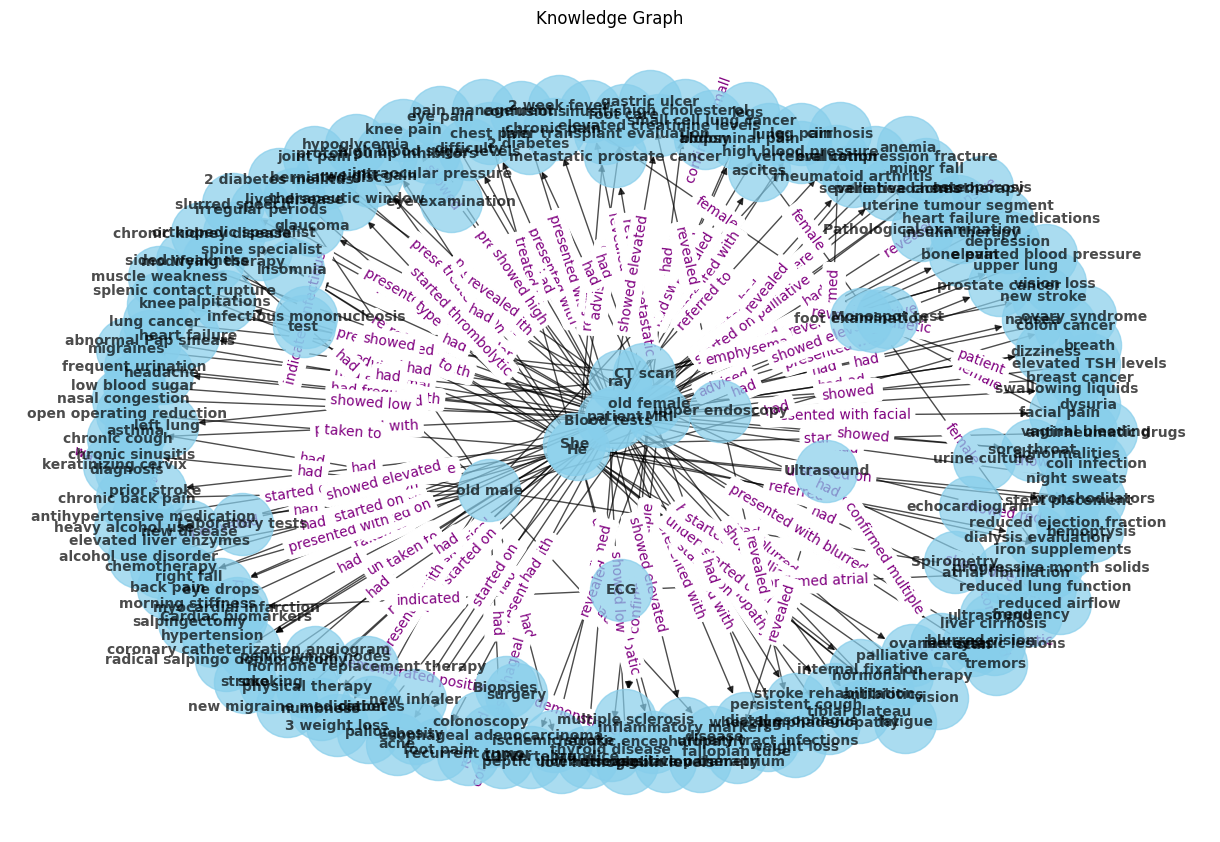

In [ ]:
# Criando um grafo direcionado
G = nx.DiGraph()

# Adicionando nós e arestas ao grafo
for index, row in gc_df.iterrows():
    G.add_edge(row['source'], row['target'], label=row['edge'])

# Plotando o grafo
pos = nx.spring_layout(G)
plt.figure(figsize=(12, 8))

# Desenhando os nós e arestas
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=10, font_weight='bold', alpha=0.7)
labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='purple', font_size=10)

# Visualização do grafo
plt.title('Knowledge Graph')
plt.show()

## Funções de manipulação

In [ ]:

# Função para adicionar um nó
def add_node(node, G):
    if not G.has_node(node):
        G.add_node(node)
        print(f"Nó '{node}' adicionado.")

# Função para adicionar uma relação (aresta)
def add_edge(source, target, edge_label, G):
    if not G.has_edge(source, target):
        G.add_edge(source, target, label=edge_label)
        print(f"Aresta de '{source}' para '{target}' com rótulo '{edge_label}' adicionada.")
    else:
        print(f"Aresta de '{source}' para '{target}' já existe.")

# Função para remover um nó
def remove_node(node, G):
    if node in G:
        G.remove_node(node)
        print(f"Nó '{node}' removido.")
    else:
        print(f"Nó '{node}' não encontrado no grafo.")

# Função para remover uma relação (aresta)
def remove_edge(source, target, G):
    if G.has_edge(source, target):
        G.remove_edge(source, target)
        print(f"Aresta de '{source}' para '{target}' removida.")
    else:
        print(f"Aresta de '{source}' para '{target}' não encontrada no grafo.")

# Função para exibir o grafo
def display_graph(G):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=10, font_weight='bold', alpha=0.7)
    labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='purple', font_size=10)
    plt.title('Knowledge Graph')
    plt.show()


# Utilizando NER para fazer Ontologia



In [ ]:
# Utilizando modelo de NER específico para medicina do Hugging Face
from transformers import pipeline
ner_model = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy='simple')

In [ ]:
exemplo_result = ner_model("A 48 year-old female presented with vaginal bleeding.")
print(exemplo_result)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity_group': 'AGE', 'score': 0.76182103, 'word': '48 year-old', 'start': 1, 'end': 13}, {'entity_group': 'SEX', 'score': 0.40471786, 'word': 'female', 'start': 13, 'end': 20}, {'entity_group': 'CLINICAL_EVENT', 'score': 0.54194367, 'word': 'presented', 'start': 20, 'end': 30}, {'entity_group': 'BIOLOGICAL_STRUCTURE', 'score': 0.23887236, 'word': 'vaginal', 'start': 35, 'end': 43}, {'entity_group': 'SIGN_SYMPTOM', 'score': 0.21539666, 'word': 'bleeding', 'start': 43, 'end': 52}]


In [ ]:
# Função responsável por categorizar e adicionar no grafo original
def process_patient(text, G):
    results = ner_model(text)
    previous_entity = None
    for entity in results:
        node = entity['word']
        entity_type = entity['entity_group']
        add_node(node, G)

        # Conecta a entidade anterior à nova entidade
        if previous_entity:
            add_edge(previous_entity['word'], node, 'related_to', G)

        # Conecta a nova entidade ao seu tipo
        add_edge(node, entity_type, 'type_of', G)

        previous_entity = entity


In [ ]:
# Iterando sobre "txt" (lista dos casos clínicos) para adicionar ao grafo original
for text in txt:
    process_patient(text, G)

Nó '48 year-old' adicionado.
Aresta de '48 year-old' para 'AGE' com rótulo 'type_of' adicionada.
Nó 'female' adicionado.
Aresta de '48 year-old' para 'female' com rótulo 'related_to' adicionada.
Aresta de 'female' para 'SEX' com rótulo 'type_of' adicionada.
Nó 'presented' adicionado.
Aresta de 'female' para 'presented' com rótulo 'related_to' adicionada.
Aresta de 'presented' para 'CLINICAL_EVENT' com rótulo 'type_of' adicionada.
Nó 'vaginal' adicionado.
Aresta de 'presented' para 'vaginal' com rótulo 'related_to' adicionada.
Aresta de 'vaginal' para 'BIOLOGICAL_STRUCTURE' com rótulo 'type_of' adicionada.
Nó 'bleeding' adicionado.
Aresta de 'vaginal' para 'bleeding' com rótulo 'related_to' adicionada.
Aresta de 'bleeding' para 'SIGN_SYMPTOM' com rótulo 'type_of' adicionada.
Nó 'abnormal' adicionado.
Aresta de 'bleeding' para 'abnormal' com rótulo 'related_to' adicionada.
Aresta de 'abnormal' para 'LAB_VALUE' com rótulo 'type_of' adicionada.
Nó 'Pap smears' adicionado.
Aresta de 'abnorm

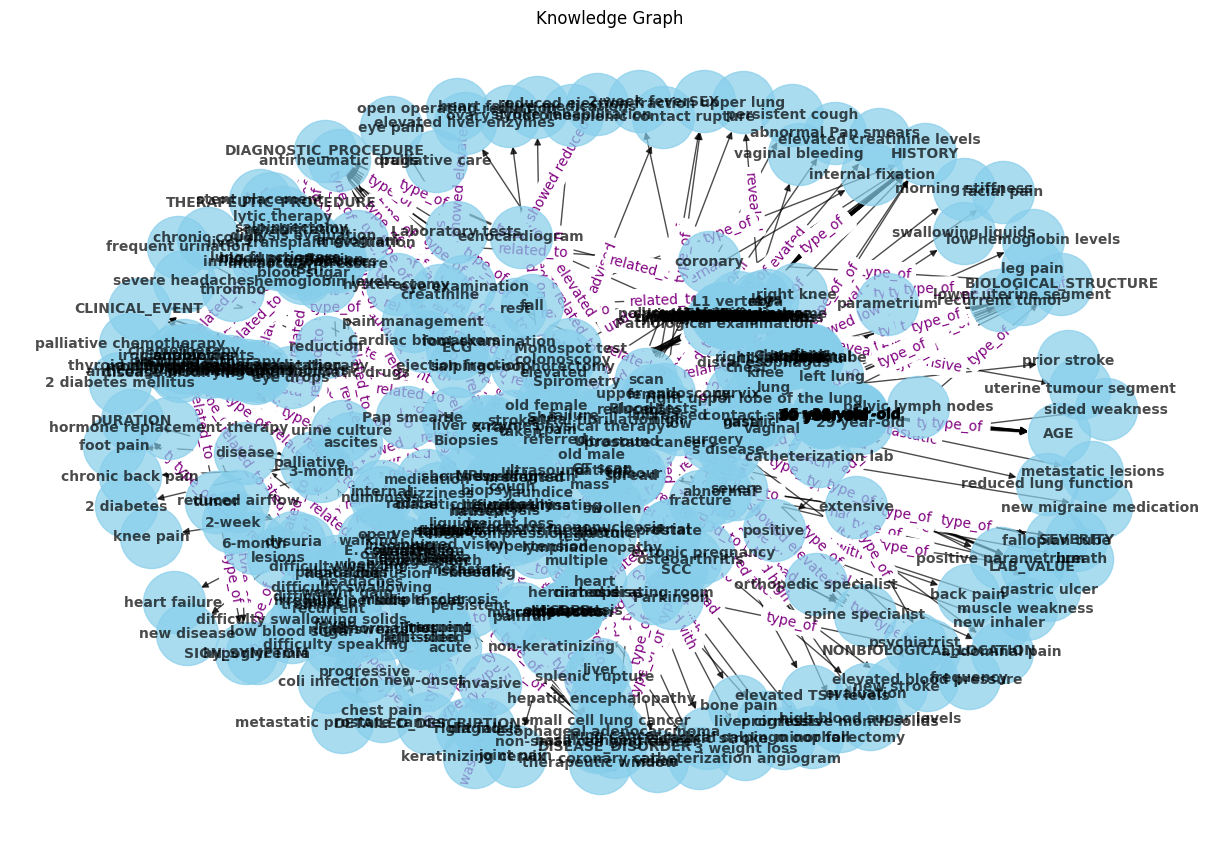

In [ ]:
display_graph(G)

In [ ]:
# Criando um novo grafo para apenas as entidades e relações do NER
G_2 = nx.DiGraph()

In [ ]:
# Iterando sobre "txt" (lista dos casos clínicos) para adicionar ao grafo novo
for text in txt:
    process_patient(text, G_2)

Nó '48 year-old' adicionado.
Aresta de '48 year-old' para 'AGE' com rótulo 'type_of' adicionada.
Nó 'female' adicionado.
Aresta de '48 year-old' para 'female' com rótulo 'related_to' adicionada.
Aresta de 'female' para 'SEX' com rótulo 'type_of' adicionada.
Nó 'presented' adicionado.
Aresta de 'female' para 'presented' com rótulo 'related_to' adicionada.
Aresta de 'presented' para 'CLINICAL_EVENT' com rótulo 'type_of' adicionada.
Nó 'vaginal' adicionado.
Aresta de 'presented' para 'vaginal' com rótulo 'related_to' adicionada.
Aresta de 'vaginal' para 'BIOLOGICAL_STRUCTURE' com rótulo 'type_of' adicionada.
Nó 'bleeding' adicionado.
Aresta de 'vaginal' para 'bleeding' com rótulo 'related_to' adicionada.
Aresta de 'bleeding' para 'SIGN_SYMPTOM' com rótulo 'type_of' adicionada.
Nó 'abnormal' adicionado.
Aresta de 'bleeding' para 'abnormal' com rótulo 'related_to' adicionada.
Aresta de 'abnormal' para 'LAB_VALUE' com rótulo 'type_of' adicionada.
Nó 'Pap smears' adicionado.
Aresta de 'abnorm

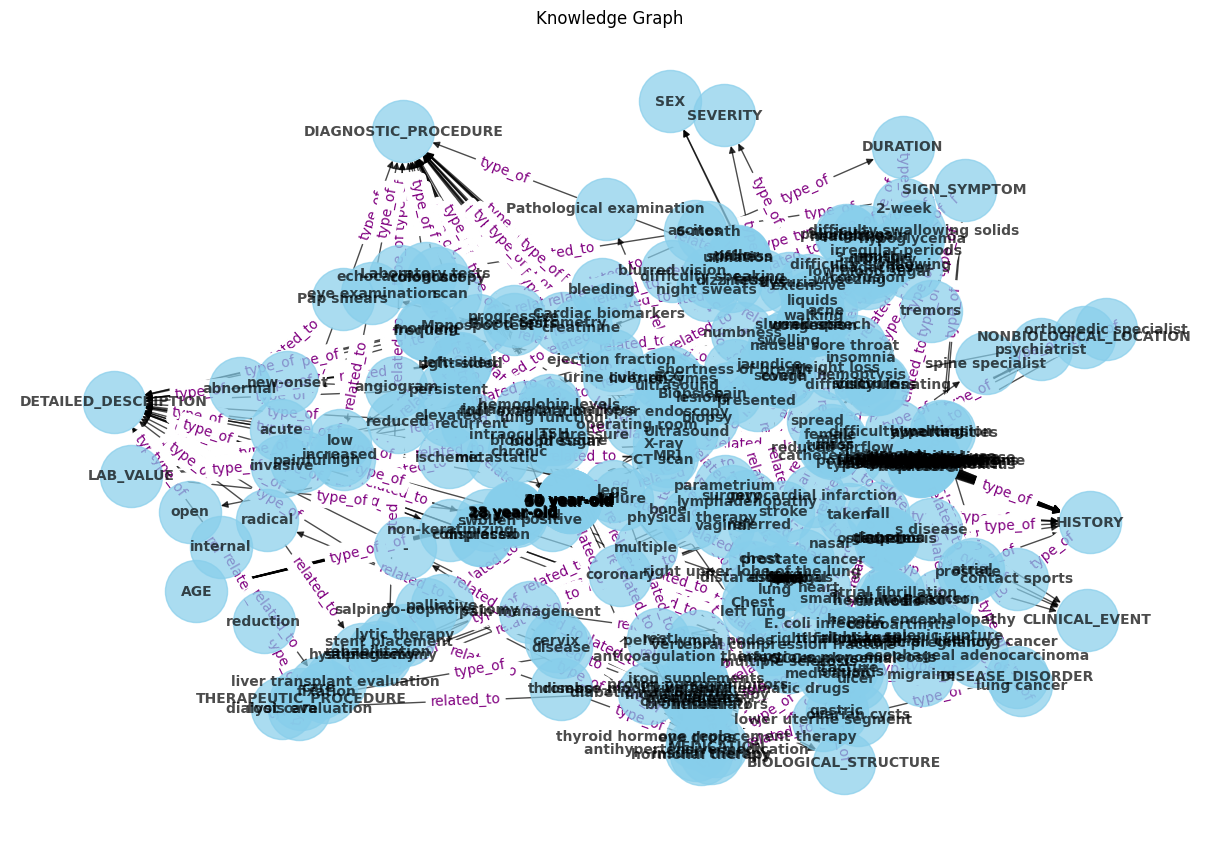

In [ ]:
# Grafo novo
display_graph(G_2)

# Filtros/Consultas

In [ ]:
# Filtro para entidade
def filter_by_entity(entity,G):
    if entity in G:
        subgraph_nodes = {entity}
        subgraph_edges = []

        for neighbor in G.neighbors(entity):
            subgraph_nodes.add(neighbor)
            subgraph_edges.append((entity, neighbor))

        subgraph = G.edge_subgraph(subgraph_edges).copy()
        display_graph(subgraph)

In [ ]:
# Filtro para relação
def filter_by_relation(relation, G):
    subgraph_edges = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == relation]
    subgraph = G.edge_subgraph(subgraph_edges)
    display_graph(subgraph)

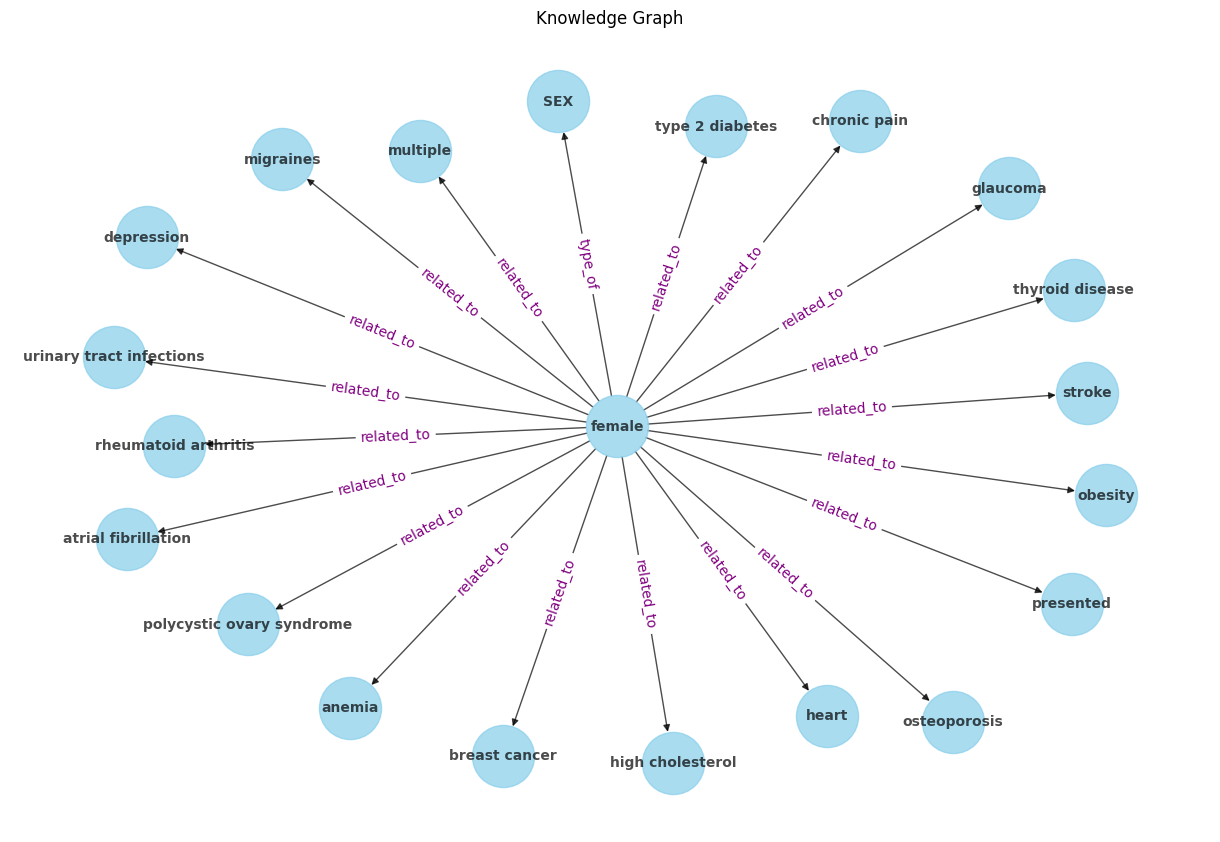

In [ ]:
filter_by_entity('female',G_2)

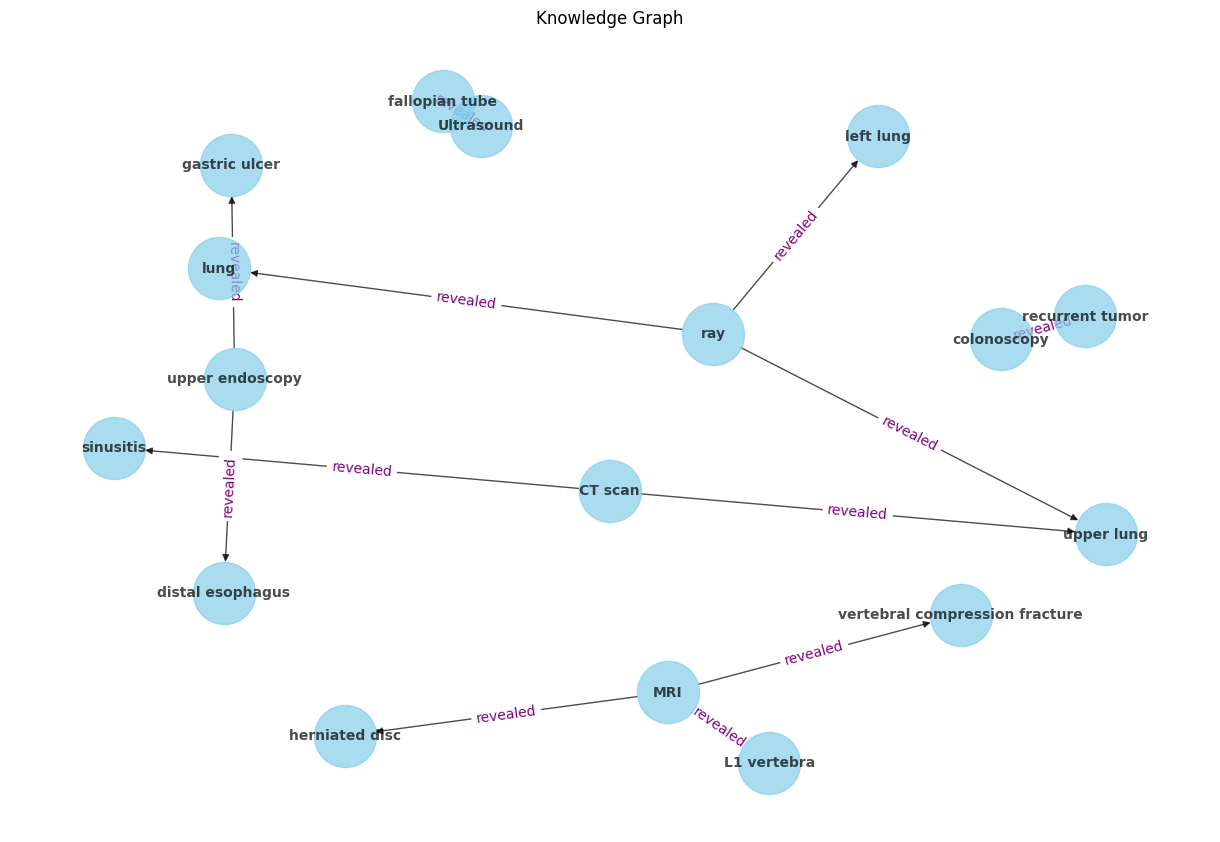

In [ ]:
filter_by_relation('revealed', G)